In [1]:
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import time

In [ ]:
#data points
#pe
#forward pe

In [2]:

start = dt.datetime(2014,1,1)
end = dt.datetime(2019,1,1)

def ticker_df(ticker, start, end):
    source = 'yahoo'
    df = web.DataReader(ticker, source, start, end)
    return df.drop(['High', 'Low', 'Open', 'Adj Close', 'Volume'], axis = 1)

#SPY = ticker_df('SPY', start, end)
IWM = ticker_df('IWM', start, end)
QQQ = ticker_df('QQQ', start, end)

In [8]:
#returns list of RSI values over n periods
def RSI(df, n):
    L = len(df)
    up = [0]*L
    down = [0]*L
    
    for i in range(1,L):
        if df['Close'][i-1] <= df['Close'][i]:
            up[i] = df['Close'][i] - df['Close'][i-1]
        if df['Close'][i-1] > df['Close'][i]:
            down[i] = abs(df['Close'][i] - df['Close'][i-1])

    avg_up= [0]*L
    avg_down = [0]*L
    
    avg_up[n] = np.mean(up[1:n+1])
    avg_down[n] = np.mean(down[1:n+1])
    
    for i in range(n+1,L):
        avg_up[i] = (avg_up[i-1]*(n-1)+up[i])/n
        avg_down[i] = (avg_down[i-1]*(n-1)+down[i])/n
    
    #return(avg_up,avg_down)
    RSI = [0]*L
    for i in range(n,L):
        RSI[i]= 100 - 100/(1+ (avg_up[i-1]/avg_down[i]))
    
    return(RSI)


##SMA, returns list of simple moving average over n periods
def SMA(stock_df,n):
    A = [0]*len(stock_df)
    for i in range(len(stock_df)-n+1):
        A[i+n-1] = np.mean(list(stock_df['Close'][i:i+n]))
    return(A)

#EMA, returns list of exponential moving average over n periods
def EMA(stock_df,n):
    mult = 2/(n+1)
    A = [0]*len(stock_df)
    A[n-1] = SMA(stock_df,n)[n-1]
    for i in range(n-1,len(stock_df)-1):
        A[i+1] = A[i]+(stock_df['Close'][i]-A[i])*mult
    return(A)

In [6]:
QQQ[' 9 RSI'] = RSI(QQQ, 9)

In [9]:
QQQ['12 EMA'] = EMA(QQQ, 12)
QQQ['26 EMA'] = EMA(QQQ, 26)

In [18]:
QQQ[25:].to_csv('dataset_QQQ_20140207_to_20181231.csv')

In [162]:
# get functions for volume action
def volm_change_pct(stock_df):
    A = [0]*len(stock_df)
    for i in range(len(stock_df)-1):
        A[i+1] = (stock_df['Volume'][i+1]-stock_df['Volume'][i])/stock_df['Volume'][i]
    return(A)

#daily pct change
def close_change_pct(stock_df):
    A = [0]*len(stock_df)
    for i in range(len(stock_df)-1):
        A[i+1] = (stock_df['Close'][i+1]-stock_df['Close'][i])/stock_df['Close'][i]
    return(A)

# normalized difference between close price and a simple moving average (close-MA)/(close+MA) over n periods
def SMA_norm_dif(stock_df,n):
    A = [0]*len(stock_df)
    B = list(stock_df['Close'])
    C = [0]*len(stock_df)
    for i in range(len(stock_df)-n+1):
        A[i+n-1] = np.mean(list(stock_df['Close'][i:i+n]))
        C[i+n-1] = (B[i+n-1]-A[i+n-1])/(B[i+n-1]+A[i+n-1])
    return C

# normalized difference between close price and a simple moving average (close-MA)/(close+MA) over n periods
#EMA, returns list of exponential moving average over n periods
def EMA_norm_dif(stock_df,n):
    mult = 2/(n+1)
    A = [0]*len(stock_df)
    A[n-1] = get_SMA(stock_df,n)[n-1]
    
    B = list(stock_df['Close'])
    C = [0]*len(stock_df)
    
    for i in range(n-1,len(stock_df)-1):
        A[i+1] = A[i]+(stock_df['Close'][i]-A[i])*mult
        C[i] = (B[i]-A[i])/(B[i]+A[i])
    return(C)

# normalized RSI
def get_RSI_norm(stock_df, n):
    RSI = get_RSI(stock_df, n)
    return([i/100 for i in RSI])

In [153]:
end = dt.datetime(2020,6,20)
start = dt.datetime(2005,1,1)
QQQ = ticker_df('QQQ', start, end)

In [8]:
# QQQ['pct chage price'] = close_change_pct(QQQ)
# QQQ['vol change pct'] = volm_change_pct(QQQ)
QQQ['12 EMA diff'] = EMA_norm_dif(QQQ,12)
QQQ['26 EMA diff'] = EMA_norm_dif(QQQ,26)
# QQQ['norm RSI 9'] = get_RSI_norm(QQQ, 9)
QQQ['12 EMA'] = get_EMA(QQQ,12)

In [9]:
QQQ.tail()

,Close,Volume,12 EMA diff,26 EMA diff,12 EMA
Date,,,,,
2020-05-22,229.660004,28762400.0,0.011776,0.024967,224.313979
2020-05-26,229.039993,33055300.0,0.008595,0.021724,225.136444
2020-05-27,230.289993,55665600.0,0.009984,0.022802,225.736990
2020-05-28,229.990005,42784300.0,0.007783,0.020426,226.437452
2020-05-29,233.360001,50878600.0,0.000000,0.000000,226.983999


In [22]:
def consol_df(stock_df):
    n1 = 9
    n2 = 12
    n3 = 26
    stock_df['RSI'] = get_RSI(stock_df,n1)
    stock_df['12 EMA'] = get_EMA(stock_df,n2)
    stock_df['26 EMA'] = get_EMA(stock_df,n3)
    return(stock_df)[n3-1:len(stock_df)]


In [24]:
QQQ_consol = consol_df(QQQ)

c:\users\olfoa\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


In [26]:
QQQ_consol.drop('Volume', axis = 1, inplace = True)

c:\users\olfoa\appdata\local\programs\python\python36\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [28]:
QQQ_consol.to_csv('QQQ_consol_20050101_to_202006021.csv')

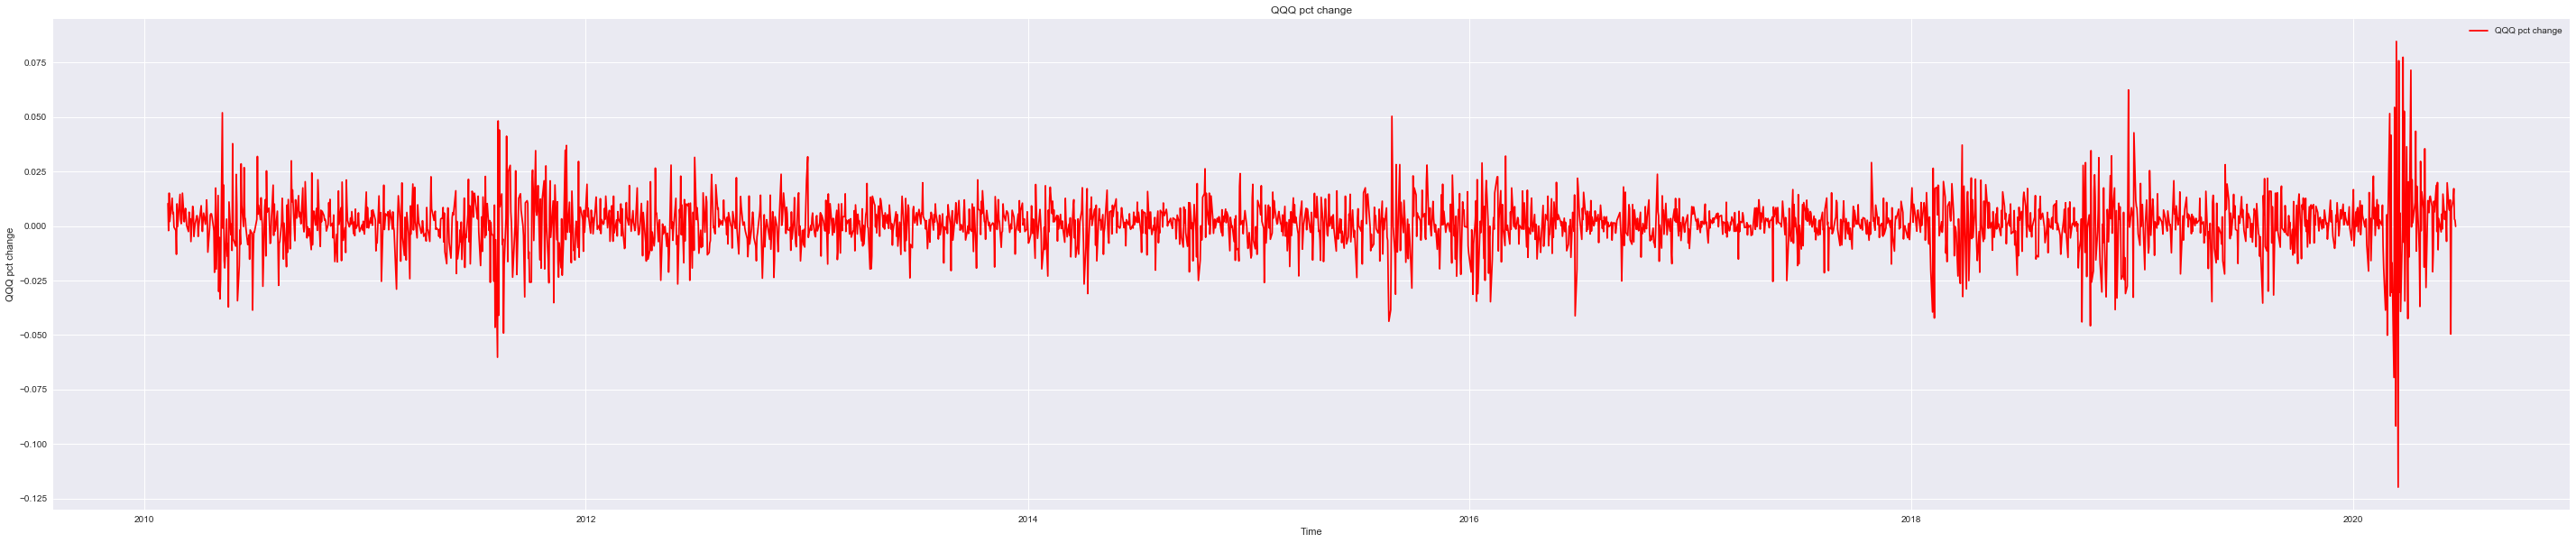

In [19]:
pct_change = test['pct change price']
plt.figure(figsize = (50,10))
plt.plot(pct_change, color = 'red', label = 'QQQ pct change')
plt.title('QQQ pct change')
plt.xlabel('Time')
plt.ylabel('QQQ pct change')
plt.legend()
plt.show()

In [27]:
QQQ_consol

,Close,RSI,12 EMA,26 EMA
Date,,,,
2005-02-08,37.740002,64.251135,37.497016,37.846538
2005-02-09,37.110001,50.188719,37.534398,37.838647
2005-02-10,37.150002,54.581722,37.469106,37.784673
2005-02-11,37.700001,55.813926,37.420013,37.737660
2005-02-14,37.869999,56.653951,37.463088,37.734871
...,...,...,...,...
2020-06-15,238.750000,55.058358,236.598966,230.995058
2020-06-16,242.850006,59.090913,236.929894,231.569498
2020-06-17,243.619995,63.019095,237.840681,232.405092
